# Omega Profiles

We plot the OMEGA profiles (`wap`) averaged over tropical ocean areas. 

- The overall mean is plotted.
- The convective mean is plotted by selecting only points with OMEGA < 0.
- Extreme precipitation points are plotted by selecting points where pr >= the 99th percentile.
- Long-duration events are defined as events longer than 5 days as determined by our detection/tracking method.
- Large events are defined as events with an average size of 12 gridpoints or more as determined by our detection/tracking method.

In [106]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
from importlib import import_module
import esmlab

to_import = "/Users/brianpm/Code/yellowstone/py"
current_path = sys.path
if to_import not in current_path:
    sys.path.append(to_import)
import extreme_precipitation_functions as prf  # get_duration_and_size(events)
import cmip_file_utils as cmip  # quick_load_var(loc, var, table, model, experiment, member)

In [100]:
# how to reload:
from importlib import reload
reload(sys.modules['cmip_file_utils'])
import cmip_file_utils as cmip

In [107]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val

In [126]:
def wap_profs(wap, pr, land):
    assert 'lat' in wap.coords
    weight = np.cos(np.radians(wap['lat']))
    if land is not None:
        wap_ocn = wap.where(land <= 0)
        pr_ocn = pr.where(land <= 0)
    else:
        wap_ocn = wap
        pr_ocn = pr
    wap_mean = esmlab.weighted_mean(wap_ocn.mean(dim=('time','lon')), dim=['lat'], weights=weight)
    wap_conv = esmlab.weighted_mean(wap_ocn.where(wap_ocn < 0).mean(dim=('time','lon')), dim=['lat'], weights=weight)
    pr_crit = get_tropics_quantiles(pr_ocn, threshold=None, q=0.99)
    wap_extreme = esmlab.weighted_mean(wap_ocn.where(pr_ocn >= pr_crit).mean(dim=('time','lon')), dim=['lat'], weights=weight)
    return wap_mean, wap_conv, wap_extreme

In [158]:
dloc = "/Volumes/Glyph6TB/CMIP6"
# tup1 = ("MRI-ESM2-0", "amip", "r1i1p1f1")
# tup2 = ("MRI-ESM2-0", "amip-lwoff", "r1i1p1f1")

# tup1 = ('IPSL-CM6A-LR', 'amip', 'r1i1p1f1')
# tup2 = ('IPSL-CM6A-LR', 'amip-lwoff', 'r1i1p1f1')
tup1 = ('IPSL-CM6A-LR', 'aqua-control', 'r1i1p1f1')
tup2 = ('IPSL-CM6A-LR', 'aqua-control-lwoff', 'r1i1p1f1')
# tup1 = ('CNRM-CM6-1', 'amip', 'r1i1p1f2')
# tup2 = ('CNRM-CM6-1', 'amip-lwoff', 'r1i1p1f2')
# tup1 = ('CNRM-CM6-1', 'aqua-control', 'r1i1p1f2')
# tup2 = ('CNRM-CM6-1', 'aqua-control-lwoff', 'r1i1p1f2')
# tup1 = ('CESM2', 'amip', 'r1i1p1f1')
# tup2 = ('CESM2', 'amip-lwoff', 'r1i1p1f1')
# tup1 = ('CESM2', 'aqua-control', 'r1i1p1f1')
# tup2 = ('CESM2', 'aqua-control-lwoff', 'r1i1p1f1')

# load the events
ev1 = xr.open_dataset(Path(dloc) / ("pr_events_"+"_".join(tup1)+".nc"))['precip_events']
ev2 = xr.open_dataset(Path(dloc) / ("pr_events_"+"_".join(tup2)+".nc"))['precip_events']

# What if we only consider events that are longer than 1-day
dursiz1 = prf.get_duration_and_size(ev1)
dursiz2 = prf.get_duration_and_size(ev2)

In [159]:
%%time
wap1 = cmip.quick_load_var(dloc, 'wap', 'day', *tup1, compute=False)
wap1_trop = wap1.sel(lat=slice(-30,30)).compute()
if 'aqua' not in tup1[1]:
    land1 = cmip.quick_load_var(dloc, "sftlf", "fx", *tup1, compute=False)
    land1_trop = land1.sel(lat=slice(-30,30)).compute()
else:
    land1 = None
    land1_trop = None
pr1 = cmip.quick_load_var(dloc, 'pr', 'day', *tup1, compute=False)
pr1_trop = pr1.sel(lat=slice(-30,30)).compute()
wap1_mean, wap1_conv, wap1_extr = wap_profs(wap1_trop, pr1_trop, land1_trop)

Quantile value: 0.00044758025964256433
CPU times: user 14.7 s, sys: 2.74 s, total: 17.5 s
Wall time: 23.1 s


In [160]:
%%time
# now we do it for the second case
wap2 = cmip.quick_load_var(dloc, 'wap', 'day', *tup2, compute=False)
pr2 = cmip.quick_load_var(dloc, 'pr', 'day', *tup2)

wap2_trop = wap2.sel(lat=slice(-30,30)).compute()
pr2_trop = pr2.sel(lat=slice(-30,30)).compute()

if 'aqua' not in tup2[1]:
    land2 = cmip.quick_load_var(dloc, "sftlf", "fx", *tup2, compute=False)
    land2_trop = land2.sel(lat=slice(-30,30)).compute()
else:
    land2 = None
    land2_trop = None

wap2_mean, wap2_conv, wap2_extr = wap_profs(wap2_trop, pr2_trop, land2_trop)

Quantile value: 0.0001830892966245307
CPU times: user 14.3 s, sys: 2.3 s, total: 16.6 s
Wall time: 22.4 s


In [161]:
duration_crit = 5  # critical value for duration
evlong1 = dursiz1.where(dursiz1['duration'] > duration_crit).dropna()
# evlong1 only has event labels for longer events.
# now we have to go and get the precipitation within those events
evmask1 = np.in1d(ev1, evlong1.index.values).reshape(ev1.shape)
evmask1 = xr.DataArray(evmask1, dims=ev1.dims, coords=ev1.coords)
pr1_long_events = pr1_trop.where(evmask1)
# now what to do with them?
# pr1_long_events  # DataArray same size as pr1_trop & ev1
wap1_long_events = wap1_trop.where(evmask1)
wap1_long_events_mean = esmlab.weighted_mean(wap1_long_events.mean(dim=('time','lon')), dim=["lat"], weights=np.cos(np.radians(wap1_trop['lat'])))

In [162]:
duration_crit = 5  # critical value for duration
evlong2 = dursiz2.where(dursiz2['duration'] > duration_crit).dropna()
# evlong1 only has event labels for longer events.
# now we have to go and get the precipitation within those events
evmask2 = np.in1d(ev2, evlong2.index.values).reshape(ev2.shape)
evmask2 = xr.DataArray(evmask2, dims=ev2.dims, coords=ev2.coords)
pr2_long_events = pr2_trop.where(evmask2)
# now what to do with them?
# pr1_long_events  # DataArray same size as pr1_trop & ev1
wap2_long_events = wap2_trop.where(evmask2)
wap2_long_events_mean = esmlab.weighted_mean(wap2_long_events.mean(dim=('time','lon')), dim=["lat"], weights=np.cos(np.radians(wap2_trop['lat'])))

In [163]:
size_crit = 12  # critical value for duration
evhuge1 = dursiz1.where(dursiz1['AvgSiz'] > duration_crit).dropna()
evmask1 = np.in1d(ev1, evhuge1.index.values).reshape(ev1.shape)
evmask1 = xr.DataArray(evmask1, dims=ev1.dims, coords=ev1.coords)
pr1_huge_events = pr1_trop.where(evmask1)
wap1_huge_events = wap1_trop.where(evmask1)
wap1_huge_events_mean = esmlab.weighted_mean(wap1_huge_events.mean(dim=('time','lon')), dim=["lat"], weights=np.cos(np.radians(wap1_trop['lat'])))

In [164]:
size_crit = 12  # critical value for duration
evhuge2 = dursiz2.where(dursiz2['AvgSiz'] > duration_crit).dropna()
evmask2 = np.in1d(ev2, evhuge2.index.values).reshape(ev2.shape)
evmask2 = xr.DataArray(evmask2, dims=ev1.dims, coords=ev2.coords)
pr2_huge_events = pr2_trop.where(evmask2)
wap2_huge_events = wap2_trop.where(evmask2)
wap2_huge_events_mean = esmlab.weighted_mean(wap2_huge_events.mean(dim=('time','lon')), dim=["lat"], weights=np.cos(np.radians(wap2_trop['lat'])))

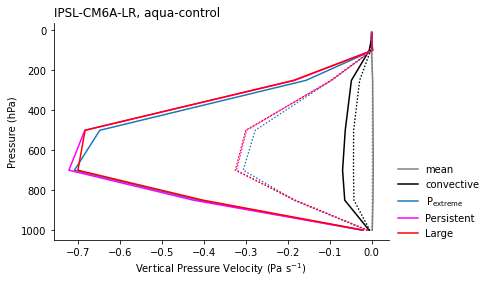

In [165]:
fig, ax = plt.subplots()
plev = wap1_trop['plev'] * 0.01 # always go back to orig to re-scale
color0 = 'gray'
color1 = 'black'
color2 = 'C0'
ax.plot(wap1_mean, plev, color=color0, label='mean')
ax.plot(wap1_conv, plev, color=color1, label='convective')
ax.plot(wap1_extr, plev, color=color2, label='P$_{\mathrm{extreme}}$')
ax.plot(wap1_long_events_mean, plev, color='magenta', label='Persistent')
ax.plot(wap1_huge_events_mean, plev, color='red', label='Large')

linsty = (0, (.25,2))
ax.plot(wap2_mean, plev, color=color0, linestyle=linsty, dash_capstyle = "round")
ax.plot(wap2_conv, plev, color=color1, linestyle=linsty, dash_capstyle = "round")
ax.plot(wap2_extr, plev, color=color2, linestyle=linsty, dash_capstyle = "round")
ax.plot(wap2_long_events_mean, plev, color='magenta', linestyle=linsty, dash_capstyle = "round")
ax.plot(wap2_huge_events_mean, plev, color='red', linestyle=linsty, dash_capstyle = "round")


ax.invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Vertical Pressure Velocity (Pa s$^{-1}$)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(f"{tup1[0]}, {tup1[1]}", loc='left')
fig.legend(bbox_to_anchor=(0.9, .1), loc='lower left', frameon=False)
figname = f"/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/wap_profiles_{tup1[0]}_{tup1[1]}_{tup2[1]}.pdf"
fig.savefig(figname, bbox_inches='tight')